# Data Preprocessing

In [ ]:
import pandas as pd
import random
from hazm import Normalizer

def clean_persian_text(text):
    normalizer = Normalizer()
    return normalizer.normalize(text)

def load_and_process_data(file_path):
    try:
        csv_dataset = pd.read_csv(file_path)
        reviews = [(clean_persian_text(text), sentiment) for text, sentiment in zip(csv_dataset['Text'], csv_dataset['Sentiment'])]
        return reviews
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return []

def filter_reviews_by_sentiment(reviews, sentiment):
    return [review for review in reviews if review[1] == sentiment]

def print_random_sample(reviews, sentiment):
    if reviews:
        print(f"{sentiment} sample : \n", random.choice(reviews))
    else:
        print(f"No {sentiment} reviews available.")


file_path = "Raw_Dataset_97P_107.csv"
reviews = load_and_process_data(file_path)

positive_reviews = filter_reviews_by_sentiment(reviews, "positive")
negative_reviews = filter_reviews_by_sentiment(reviews, "negative")
neutral_reviews = filter_reviews_by_sentiment(reviews, "neutral")

balanced_reviews = positive_reviews[:2500] + negative_reviews[:2500]
random.shuffle(balanced_reviews)

In [ ]:
import matplotlib.pyplot as plt

# Count of each sentiment category
sentiment_counts = {
    "Positive": len(positive_reviews),
    "Negative": len(negative_reviews),
    "Neutral": len(neutral_reviews),
}

# Total count of reviews
total_count = len(reviews)

# Display counts in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'blue'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis Results")
plt.show()

# Display random samples
print("\nRandom Samples:")
print(f"Positive Sample: {print_random_sample(positive_reviews, 'Positive')}")
print(f"Negative Sample: {print_random_sample(negative_reviews, 'Negative')}")
print(f"Neutral Sample: {print_random_sample(neutral_reviews, 'Neutral')}")

# Display count of the balanced dataset
print(f"\nBalanced dataset count: {len(balanced_reviews)}")

# Data Preparation for Text Classification

In [ ]:
import numpy as np
from keras import backend as K

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens
TRAIN_TEST_SPLIT = 0.8  # Proportion of the data to be used for training

def split_data(data, train_test_split):
    train_size = int(train_test_split * len(data))
    test_size = len(data) - train_size
    return train_size, test_size

def initialize_arrays(train_size, test_size, max_tokens, VECTOR_SIZE):
    x_train = np.zeros((train_size, max_tokens, VECTOR_SIZE), dtype=K.floatx())
    y_train = np.zeros((train_size, 2), dtype=np.int32)

    x_test = np.zeros((test_size, max_tokens, VECTOR_SIZE), dtype=K.floatx())
    y_test = np.zeros((test_size, 2), dtype=np.int32)

    return x_train, y_train, x_test, y_test

train_size, test_size = split_data(balanced_reviews, TRAIN_TEST_SPLIT)
x_train, y_train, x_test, y_test = initialize_arrays(train_size, test_size, MAX_NO_TOKENS, VECTOR_SIZE)

In [17]:
import tabulate

# Shapes of the arrays
shapes_data = [
    ["x_train", x_train.shape],
    ["x_test", x_test.shape],
    ["y_train", y_train.shape],
    ["y_test", y_test.shape]
]

# Display vocabulary size and array shapes in a table
table = tabulate.tabulate(shapes_data, headers=["Item", "Shape/Size"], tablefmt="fancy_grid")
print("Data Information:")
print(table)

Data Information:
╒═════════╤══════════════════╕
│ Item    │ Shape/Size       │
╞═════════╪══════════════════╡
│ x_train │ (4000, 107, 300) │
├─────────┼──────────────────┤
│ x_test  │ (1000, 107, 300) │
├─────────┼──────────────────┤
│ y_train │ (4000, 2)        │
├─────────┼──────────────────┤
│ y_test  │ (1000, 2)        │
╘═════════╧══════════════════╛


# Text Vectorization and Sentiment Classification

In [ ]:
import numpy as np
import fasttext
import hazm

def load_fasttext_model(model_path):
    return fasttext.load_model(model_path)

def tokenize_text(text, tokenizer, max_tokens):
    return tokenizer.tokenize(text)[:max_tokens]

def vectorize_text(text, model, max_tokens):
    return [model.get_word_vector(word) for word in text if word in model.words][:max_tokens]

def process_reviews(reviews, model, tokenizer, max_tokens, label_map):
    x_data = []
    y_data = []
    unique_words = set()

    for text, sentiment in reviews:
        tokenized_text = tokenize_text(text, tokenizer, max_tokens)
        unique_words.update(tokenized_text)
        vectorized_text = vectorize_text(tokenized_text, model, max_tokens)

        if not vectorized_text:
            continue

        padded_vector = np.zeros((max_tokens, model.get_dimension()), dtype=np.float32)
        padded_vector[:len(vectorized_text), :] = vectorized_text

        x_data.append(padded_vector)
        y_data.append(label_map.get(sentiment, label_map['other']))

    return np.array(x_data), np.array(y_data), len(unique_words)

# Load model and tokenizer
W2V_Model = load_fasttext_model("Facebook_Embedding_Model_300.bin")
tokenizer = hazm.WordTokenizer()

# Assuming 'balanced_reviews' is a list of (text, sentiment) tuples
all_reviews = balanced_reviews  # Use the complete set of reviews
train_reviews = balanced_reviews[:train_size]
test_reviews = balanced_reviews[train_size:]

# Define a mapping for sentiment to binary labels
sentiment_label_map = {"negative": [1.0, 0.0], 'other': [0.0, 1.0]}  # Adjust based on actual labels

x_train, y_train, vocabulary_size = process_reviews(train_reviews, W2V_Model, tokenizer, MAX_NO_TOKENS, sentiment_label_map)
x_test, y_test, _ = process_reviews(test_reviews, W2V_Model, tokenizer, MAX_NO_TOKENS, sentiment_label_map)

In [15]:
import tabulate

# Shapes of the arrays
shapes_data = [
    ["x_train", x_train.shape],
    ["x_test", x_test.shape],
    ["y_train", y_train.shape],
    ["y_test", y_test.shape]
]

# Display vocabulary size and array shapes in a table
table = tabulate.tabulate(shapes_data, headers=["Item", "Shape/Size"], tablefmt="fancy_grid")
print("Data Information:")
print(table)

Data Information:
╒═════════╤══════════════════╕
│ Item    │ Shape/Size       │
╞═════════╪══════════════════╡
│ x_train │ (4000, 107, 300) │
├─────────┼──────────────────┤
│ x_test  │ (1000, 107, 300) │
├─────────┼──────────────────┤
│ y_train │ (4000, 2)        │
├─────────┼──────────────────┤
│ y_test  │ (1000, 2)        │
╘═════════╧══════════════════╛


# Saving Data and Cleaning Resources

In [ ]:
np.save("x_train_Facebook_Small.npy", x_train)
np.save("x_test_Facebook_Small.npy", x_test)
np.save("y_train_Facebook_Small.npy", y_train)
np.save("y_test_Facebook_Small.npy", y_test)
del W2V_Model

# Data Loading and Main Configuration

In [1]:
import fasttext
import hazm
import numpy as np
from keras import backend as K
import pandas as pd
import random
from hazm import Normalizer

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens

BATCH_SIZE = 512
NUM_EPOCHS = 100

x_train = np.load("./Facebook_Dataset/x_train_Facebook.npy")[:4000, :, :]
x_test = np.load("./Facebook_Dataset/x_test_FaceBook.npy" )[:1000, :, :]

y_train = np.load("./Facebook_Dataset/y_train_Facebook.npy")[:4000, :]
y_test = np.load("./Facebook_Dataset/y_test_Facebook.npy")[:1000, :]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

2024-01-28 08:31:10.376309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 08:31:10.376343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 08:31:10.377150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 08:31:10.382832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4000, 107, 300) (1000, 107, 300) (4000, 2) (1000, 2)


# Convolutional Neural Network (LSTM) Model Definition

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()

# Bidirectional LSTM with Dropout and L2 Regularization
model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)), input_shape=(MAX_NO_TOKENS, VECTOR_SIZE)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(16, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01))))

# Dense Layer with Dropout and L2 Regularization
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

2024-01-28 08:31:22.475996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 08:31:22.514847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 08:31:22.515030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 107, 64)           85248     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 107, 64)           256       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                        

In [3]:
from tensorflow.keras.callbacks import CSVLogger

# Filepath to save the CSV log
csv_logger_filepath = 'LSTM_Small_Facebook_Result.csv'

# Create CSVLogger callback
csv_logger = CSVLogger(csv_logger_filepath, append=True)

# Fit the model
history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=NUM_EPOCHS, 
    shuffle=True, 
    validation_data=(x_test, y_test),
    callbacks=[csv_logger]
)

2024-01-28 08:31:52.314483: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513600000 exceeds 10% of free system memory.
2024-01-28 08:31:52.783858: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513600000 exceeds 10% of free system memory.


Epoch 1/100


2024-01-28 08:32:01.065792: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:32:01.065887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:32:01.065931: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65740800 exceeds 10% of free system memory.
2024-01-28 08:32:03.287810: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcde4408910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 08:32:03.287836: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 with Max-Q Design, Compute Capability 6.1
2024-01-28 08:32:03.293369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-28

8/8 [==============================] - 20s 1s/step - loss: 5.6421 - accuracy: 0.5200 - val_loss: 5.3953 - val_accuracy: 0.5530
Epoch 2/100
8/8 [==============================] - 7s 856ms/step - loss: 5.2561 - accuracy: 0.5275 - val_loss: 5.0411 - val_accuracy: 0.5670
Epoch 3/100
8/8 [==============================] - 7s 818ms/step - loss: 4.8998 - accuracy: 0.5235 - val_loss: 4.7067 - val_accuracy: 0.5210
Epoch 4/100
8/8 [==============================] - 8s 962ms/step - loss: 4.5691 - accuracy: 0.5355 - val_loss: 4.3930 - val_accuracy: 0.5140
Epoch 5/100
8/8 [==============================] - 8s 970ms/step - loss: 4.2615 - accuracy: 0.5420 - val_loss: 4.1015 - val_accuracy: 0.5170
Epoch 6/100
8/8 [==============================] - 8s 957ms/step - loss: 3.9804 - accuracy: 0.5365 - val_loss: 3.8317 - val_accuracy: 0.5210
Epoch 7/100
8/8 [==============================] - 8s 969ms/step - loss: 3.7080 - accuracy: 0.5748 - val_loss: 3.5828 - val_accuracy: 0.5270
Epoch 8/100
8/8 [==========

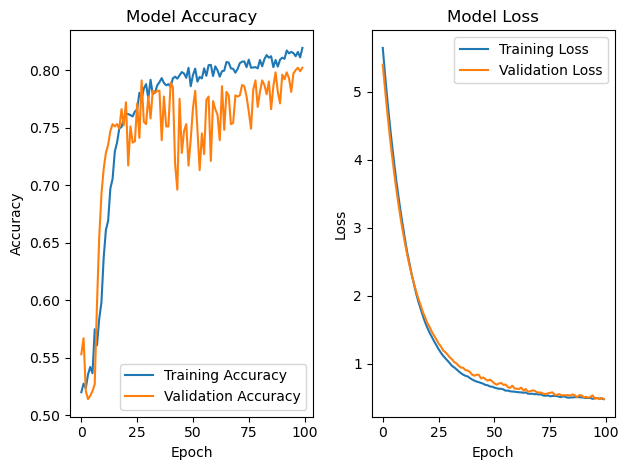

In [4]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that contains your model training history.
# Replace 'history' with the actual name of the variable if it's different.

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [5]:
model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)

32/32 [==============================] - 3s 84ms/step - loss: 0.4858 - accuracy: 0.8020


[0.48584961891174316, 0.8019999861717224]

In [6]:
model.save('LSTM_Small_Facebook_80P.model')

INFO:tensorflow:Assets written to: LSTM_Small_Facebook_80P.model/assets


INFO:tensorflow:Assets written to: LSTM_Small_Facebook_80P.model/assets


# Model Loading and Configuration

In [4]:
import fasttext
import hazm
import numpy as np
from keras import backend as K
import pandas as pd
import random
from hazm import Normalizer
from tensorflow.keras.models import load_model

VECTOR_SIZE = 300  # Dimension of the vectors
MAX_NO_TOKENS = 107  # Maximum number of tokens

model = load_model("LSTM_Small_Facebook_80P.model")
W2V_Model = fasttext.load_model("Facebook_Embedding_Model_300.bin")

In [8]:
import numpy as np
import hazm
from keras import backend as K
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import clear_output

# Define the function for normalization and tokenization
def normalize_and_tokenize(text):
    normalizer = hazm.Normalizer()
    return hazm.word_tokenize(normalizer.normalize(text))

# Define the function for vectorizing text
def vectorize_text(words, model, max_tokens, vector_size):
    vectors = [model.get_word_vector(word) for word in words if word in model.words][:max_tokens]
    x_vectors = np.zeros((1, max_tokens, vector_size), dtype=K.floatx())
    x_vectors[0, :len(vectors), :] = vectors
    return x_vectors

# Define the function to display sentiment analysis results
def display_sentiment(result, images_src_path='./Assets/Images/'):
    pos_percent = f"{int(result[0][1] * 100)} % "
    neg_percent = f"{int(result[0][0] * 100)} % "
    html_content = f"<div style='text-align: center'><div style='display:inline-block'><img height='64px' width='64px' src='{images_src_path}smile.png'/><h4>{pos_percent}</h4></div> | <div style='display:inline-block'><img height='64px' width='64px' src='{images_src_path}angry.png'/><h4>{neg_percent}</h4></div></div>"
    display(HTML(html_content))

# Callback function to process and display results
def on_text_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        user_text = change['new']
        if user_text:
            tokenized_text = normalize_and_tokenize(user_text)
            x_text_vectors = vectorize_text(tokenized_text, W2V_Model, MAX_NO_TOKENS, VECTOR_SIZE)
            result = model.predict(x_text_vectors)  # Replace 'model' with your trained model
            display_sentiment(result)
        else:
            print("Please enter your text")

# Create a text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Input:',
    continuous_update=False,  # Set to False to trigger the event only when the user stops typing
    disabled=False
)

# Display the text input widget
display(text_input)

# Set the callback function for text input
text_input.observe(on_text_change, names='value')


Text(value='', continuous_update=False, description='Input:', placeholder='Type something')